In [1]:
import os
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import trompy as tp
import pandas as pd
from scipy import stats

In [2]:
def get_number_cells (s2p_folder):
    iscell = np.load(os.path.join(s2p_folder, 'iscell.npy'))
    return sum(iscell[:,0])
    

In [3]:
def get_frames(events_file,s2p_length):
    df = pd.read_csv(events_file)

    pump_frames = list(df[df['Item1'] == 'pump_on']['Item2.Item2'])

    pump_frames=[frame for frame in pump_frames if frame < s2p_length-100] #removes event if too close to the end

    licks_frames = list (df[df['Item1']== 'Lick']['Item2.Item2'])
    
    licks_frames=[frame for frame in licks_frames if frame < s2p_length-100] #removes event if too close to the end
    
    return pump_frames, licks_frames

In [4]:
def filter_cell(x):

    t = np.arange(0,len(x)/10,0.1)
    filt = signal.butter(4, 1, 'low', fs=10, output='sos')
    filtered = signal.sosfilt(filt, x)
    
    return filtered
    

In [5]:
def get_activated_cells (s2p_folder,events_file):
    raw_F = np.load(os.path.join(s2p_folder, 'F.npy'))
    neu_F = np.load(os.path.join(s2p_folder, 'Fneu.npy'))
    iscell = np.load(os.path.join(s2p_folder, 'iscell.npy'))
    
    s2p_length=len(raw_F[0,:])
    
    pump_frames, licks_frames= get_frames(events_file,s2p_length)
    
    cell_idx = [idx for idx,vals in enumerate(iscell) if vals[0]==1]
    
    activated_cells=0
    all_cells=cell_idx
    pump_activated_cells=[]
    pump_inhibited_cells=[]
    lick_activated_cells=[]
    lick_inhibited_cells=[]

    for i, cell in enumerate(cell_idx):
        x = raw_F[cell, :] - 0.7*(neu_F[cell, :])
#         x = raw_F[cell, :]
        x = (x - np.mean(x))/np.std(x)
        x = filter_cell(x)

        
        
        #Extracting pump activated and inhibited cells  
        pre=[]
        post=[]
        
        for p in pump_frames:
            pre.append(np.mean(x[p-50:p]))
            post.append(np.mean(x[p:p+50]))
        result_pump= stats.ttest_rel(pre, post)
        
        p=result_pump[1]        
        if (p < 0.05) and (np.mean(pre) < np.mean(post)): 
            pump_activated_cells.append(cell)
        if (p < 0.05) and (np.mean(pre) > np.mean(post)):
            pump_inhibited_cells.append(cell)   
        
        #Extracting licks   
        #get frist lick in trials (trial 10 sec from pump on)
        licks=[]
        for p in pump_frames: 
            temp=[]
            for l in licks_frames: 
                if l > p and l < p + 100: 
                    temp.append(l)                
            licks.append(temp)
            
        # Excluding trials without licks
        temp_lick=[]
        for trial in licks:
            if len(trial) > 0: 
                temp_lick.append(trial[:1])
        # List comprehention to make list of list into list of floats
        first_lick=[trial for sublist in temp_lick for trial in sublist] 
        
        # Extracting lick activated and inhibited cells 

        pre_lick=[]
        post_lick=[]
        
        for p in first_lick:
            pre_lick.append(np.mean(x[p-50:p]))
            post_lick.append(np.mean(x[p:p+50]))
        lick_result= stats.ttest_rel(pre_lick, post_lick)
        
        p=lick_result[1]
        if (p < 0.05) and (np.mean(pre_lick) < np.mean(post_lick)):  
            lick_activated_cells.append(cell)        
        if (p < 0.05) and (np.mean(pre_lick) > np.mean(post_lick)):
            lick_inhibited_cells.append(cell)

    
    return all_cells, pump_activated_cells,pump_inhibited_cells,lick_activated_cells,lick_inhibited_cells

In [6]:
def get_snips_responsive_cells (s2p_folder,events_file):
   
    raw_F = np.load(os.path.join(s2p_folder, 'F.npy'))
    neu_F = np.load(os.path.join(s2p_folder, 'Fneu.npy'))
    iscell = np.load(os.path.join(s2p_folder, 'iscell.npy'))
    
    s2p_length=len(raw_F[0,:])
    
    pump_frames, licks_frames= get_frames(events_file,s2p_length)
    
    cell_idx = [idx for idx,vals in enumerate(iscell) if vals[0]==1]
    
    activated_cells=0
    
    snips_lick=[]
    snips_pump=[]
    mean_lick_a_snips=[]
    mean_lick_i_snips=[]
    mean_pump_a_snips=[]
    mean_pump_i_snips=[]
    

    for i, cell in enumerate(cell_idx):
        x = raw_F[cell, :] - 0.7*(neu_F[cell, :])
#         x = raw_F[cell, :]
        x = (x - np.mean(x))/np.std(x)
        x = filter_cell(x)
        
        
        
        #Extracting snips from pump activated and inhibited cells  
        pump_snips = []
        pre=[]
        post=[]
        
        for p in pump_frames:
            pump_snips.append(x[p-50:p+100])
            pre.append(np.mean(x[p-50:p]))
            post.append(np.mean(x[p:p+50]))
        result_pump= stats.ttest_rel(pre, post)
        temp_pump_snips=np.mean(pump_snips, axis=0)
        snips_pump.append(temp_pump_snips)
        
        p=result_pump[1]        
        if (p < 0.05) and (np.mean(pre) < np.mean(post)): 
            mean_pump_a_snips.append(temp_pump_snips)
        if (p < 0.05) and (np.mean(pre) > np.mean(post)):
            mean_pump_i_snips.append(temp_pump_snips)  
        
        #Extracting licks   
        #get frist lick in trials (trial 10 sec from pump on)
        licks=[]
        for p in pump_frames: 
            temp=[]
            for l in licks_frames: 
                if l > p and l < p + 100: 
                    temp.append(l)                
            licks.append(temp)
            
        # Excluding trials without licks
        temp_lick=[]
        for trial in licks:
            if len(trial) > 0: 
                temp_lick.append(trial[:1])
        # List comprehention to make list of list into list of floats
        first_lick=[trial for sublist in temp_lick for trial in sublist] 
        
        # Extracting snips from lick activated and inhibited cells 
        lick_snips=[]
        pre_lick=[]
        post_lick=[]
        
        for p in first_lick:
            lick_snips.append(x[p-50:p+100])
            pre_lick.append(np.mean(x[p-50:p]))
            post_lick.append(np.mean(x[p:p+50]))
        lick_result= stats.ttest_rel(pre_lick, post_lick)
        temp_lick_snips=np.mean(lick_snips, axis=0)
        snips_lick.append(temp_lick_snips)
        
        p=lick_result[1]
        if (p < 0.05) and (np.mean(pre_lick) < np.mean(post_lick)):  
            mean_lick_a_snips.append(temp_lick_snips)
        if (p < 0.05) and (np.mean(pre_lick) > np.mean(post_lick)):
            mean_lick_i_snips.append(temp_lick_snips)
            
    return   snips_lick,snips_pump,mean_lick_a_snips, mean_lick_i_snips, mean_pump_a_snips, mean_pump_i_snips


In [7]:
def make_heatmap(data, events=None, ax=None, cmap="jet", sort=True, ylabel="Trials", clims=[-0.45,0.8]):

    if ax == None:
        f, ax = plt.subplots()

    (ntrials, bins) = np.shape(data)
    
    print(ntrials, bins)
    

    xvals = np.linspace(-5,10,bins)
    yvals = np.arange(0, ntrials)
    xx, yy = np.meshgrid(xvals, yvals)

    if sort == True:
        try:
            inds = np.argsort(events)
            data = [data[i] for i in inds]
            events = [events[i] for i in inds]
        except:
            print("Events cannot be sorted")

    mesh = ax.pcolormesh(xx, yy, data, cmap=cmap, shading="auto")
    mesh.set_clim(clims)
    
    ax.set_ylabel('Cell number',fontsize = 13)
    ax.set_xlabel('Time from pump on (s)', fontsize = 13)
    ax.set_xticks([-5,0,5,10])
    ax.set_xticklabels([-5,0,5,10], fontsize= 13)
    ax.set_yticks([0,25,50,75])
    ax.set_yticklabels([0,25,50,75], fontsize= 13)
    ax.axvline(0, color='black', alpha=1, linewidth=2, linestyle='--')

#     if events:
#         ax.vlines(events, yvals-0.5, yvals+0.5, color='w')

#     ax.set_ylabel(ylabel, rotation=90, labelpad=2)

#     ax.invert_yaxis()
#     ax.set_yticks([])
#     ax.set_xticks([])
#     ax.spines['bottom'].set_visible(False)
#     ax.spines['left'].set_visible(False)

    return ax, mesh

# Dictionary 

In [44]:
rows,header=tp.metafilereader('C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\Metafile_VGP2.3.xls',sheetname='2panalysispilot')
folder= 'C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\VGP2\\Bonsai\\'

File is excel file. Making csv metafile first


In [8]:
ROOT_FOLDER = "C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\VGP2"

DATA_FOLDER = os.path.join(ROOT_FOLDER, "Processed\\s2p")
BEHAV_FOLDER = os.path.join(ROOT_FOLDER, "Bonsai\\")
METAFILE = os.path.join(ROOT_FOLDER, "Metafile_VGP2.3.xls")
rows, header = tp.metafilereader(METAFILE, sheetname="2panalysispilot")

File is excel file. Making csv metafile first


In [14]:
cell_data={}

for row in rows: 
    try: 
        
        key=row[0]+'_'+row[1]
        animal=row[0]
        day=row[1]
        date=int(row[3])
        events=row[5]
    
        s2p_folder = os.path.join(DATA_FOLDER, "sub-{}\\ses-{}".format(animal, day))
        events_file =BEHAV_FOLDER+events
        
    
        filtered = filter_cell # not sure if i need this in the dictionary? 
        
        #Event responsive cells, ROI and number
        (all_cells, 
        pump_activated_cells,
        pump_inhibited_cells,
        lick_activated_cells,
        lick_inhibited_cells) = get_activated_cells (s2p_folder,events_file)
        both_activated= list(set(pump_activated_cells)& set(lick_activated_cells))
        both_inhibited= list(set(pump_inhibited_cells)& set(lick_inhibited_cells))
        pump_a_only=len(pump_activated_cells)-len(both_activated)
        pump_i_only=len(pump_inhibited_cells)-len(both_inhibited)
        lick_a_only=len(lick_activated_cells)-len(both_activated)
        lick_i_only=len(lick_inhibited_cells)-len(both_inhibited)
        
        
        #Get snips 
        (snips_lick,
         snips_pump,
         mean_lick_a_snips, 
         mean_lick_i_snips, 
         mean_pump_a_snips, 
         mean_pump_i_snips)=get_snips_responsive_cells (s2p_folder,events_file)
       
        cell_data[key]={}
        cell_data[key]['animal'] = row[0]
        cell_data[key]['diet']=row[4]
        cell_data[key]['solution']=row[2]
        
        #ROI label/of event responsive cells
        cell_data[key]['all cells'] = all_cells
        
        cell_data[key]['pump activated cells']=pump_activated_cells
        cell_data[key]['pump inhibited cells']= pump_inhibited_cells
        cell_data[key]['lick activated cells']= lick_activated_cells
        cell_data[key]['lick inhibited cells']= lick_inhibited_cells
        cell_data[key]['both activated cells'] = both_activated
        cell_data[key]['both inhibited cells'] = both_inhibited
    
        
        #Number of event responsive cells to  make pie chart 
        cell_data[key]['n pump activated']=pump_a_only
        cell_data[key]['n pump inhibited']=pump_i_only
        cell_data[key]['n lick activated']=lick_a_only
        cell_data[key]['n lick inhibited']=lick_i_only
        cell_data[key]['n both activated']=len(both_activated)
        cell_data[key]['n both inhibited']=len(both_inhibited)
        cell_data[key]['pump responsive']= pump_a_only + pump_i_only
        cell_data[key]['% pump responsive']= (pump_a_only+pump_i_only)/len(all_cells)*100
        cell_data[key]['lick responsive']= lick_a_only+lick_i_only
        cell_data[key]['% lick responsive']= (lick_a_only+lick_i_only)/len(all_cells)*100
        cell_data[key]['both responsive']= both_activated+both_inhibited
        cell_data[key]['% both responsive']= (pump_a_only+pump_i_only+lick_a_only+lick_i_only)/len(all_cells)*100
        cell_data[key]['n none responsive']=len(all_cells)-(pump_a_only+pump_i_only+lick_a_only+lick_i_only+len(both_activated)+len(both_inhibited))
        cell_data[key]['n cells']=len(all_cells)
        
       
        #Snips of responsive cells
        cell_data[key]['lick snips']=snips_lick
        cell_data[key]['pump snips']=snips_pump
        cell_data[key]['snips pump a']=mean_pump_a_snips
        cell_data[key]['snips pump i']=mean_pump_i_snips
        cell_data[key]['snips lick a']=mean_lick_a_snips
        cell_data[key]['snips lick i']=mean_lick_i_snips
        
    except FileNotFoundError: 
        print('Cannot find file for', key)

In [18]:
cell_data['VGP505_037']

{'animal': 'VGP505',
 'diet': 'PR',
 'solution': 'Cas',
 'all cells': [7,
  8,
  11,
  12,
  14,
  17,
  19,
  23,
  24,
  26,
  30,
  31,
  37,
  38,
  40,
  43,
  45,
  46,
  54,
  57,
  59,
  61,
  62,
  64,
  67,
  70,
  72,
  74,
  75,
  76,
  77,
  78,
  79,
  81,
  82,
  84,
  87,
  88,
  89,
  93,
  95,
  99,
  104,
  106,
  109,
  110,
  111,
  112,
  113],
 'pump activated cells': [30, 31, 61, 89, 99, 113],
 'pump inhibited cells': [],
 'lick activated cells': [14,
  17,
  31,
  37,
  45,
  46,
  57,
  59,
  61,
  64,
  67,
  70,
  75,
  76,
  77,
  81,
  82,
  87,
  89,
  93,
  99,
  106,
  109,
  110,
  112,
  113],
 'lick inhibited cells': [38, 40, 62, 78],
 'both activated cells': [99, 113, 89, 61, 31],
 'both inhibited cells': [],
 'n pump activated': 1,
 'n pump inhibited': 0,
 'n lick activated': 21,
 'n lick inhibited': 4,
 'n both activated': 5,
 'n both inhibited': 0,
 'pump responsive': 1,
 '% pump responsive': 2.0408163265306123,
 'lick responsive': 25,
 '% lick r

# Making pie chart list

In [16]:

for key in cell_data.keys():
    d=cell_data[key]
    if d['solution'] == 'Baseline' and d['diet']== 'NR' and d['animal']== 'VGP403':
        pump_a_cell=(d['n pump activated'])
        pump_i_cell=(d['n pump inhibited'])
        lick_a_cell=(d['n lick activated'])
        lick_i_cell=(d['n lick inhibited'])
        both_a_cell=d['n both activated']
        both_i_cell=d['n both inhibited']
        none_responsive=d['n none responsive']
        
        pump_responsive= pump_a_cell + pump_i_cell
        lick_responsive=lick_a_cell+lick_i_cell
        both_responsive=both_a_cell+both_i_cell
        
        
       
        
sizes= [pump_a_cell,lick_a_cell,both_a_cell,none_responsive]        
labels=['Pump', 'Lick ', 'Both', 'None']
colors=['green','red', 'yellow','dimgrey']
f1, ax1 = plt.subplots(figsize=[3,3], )
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors,labeldistance=None,radius=1,counterclock=False)
ax1.legend()


# f1.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\pie_118_cas.png')

both_responsive

NameError: name 'pump_a_cell' is not defined

## Ca2+ activity activated cells

In [12]:
for key in cell_data.keys():
    d=cell_data[key]
    if d['solution'] == 'Baseline' and d['diet']== 'NR'and d['animal']== 'VGP403':
        lick_snips_a=d['snips lick a']
        lick_snips_i=d['snips lick i']
        pump_snips_a=d['snips pump a']
        pump_snips_i=d['snips pump i']
#         snips_lick_cas=d['lick snips']
#         snips_pump_cas=d['pump snips']
        
#     elif d['solution'] == 'malt' and d['diet']== 'PR'and d['animal']== 'VGP118':
#         lick_snips_malt=d['snips lick a']
#         lick_snips_malt_i=d['snips lick i']
#         pump_snips_malt=d['snips pump a']
#         snips_lick_malt=d['lick snips']
        
#     elif d['solution'] == 'cas' and d['diet']== 'PRNR'and d['animal']== 'VGP118':
#         lick_snips_cas2=d['snips lick a']
#         pump_snips_cas2=d['snips pump a']
#         snips_lick_cas2=d['lick snips']
        
#     elif d['solution'] == 'malt' and d['diet']== 'PRNR'and d['animal']== 'VGP118':
#         lick_snips_malt2=d['snips lick a']
#         lick_snips_malt2_i=d['snips lick i']
#         pump_snips_malt2=d['snips pump a']
#         snips_lick_malt2=d['lick snips']

        
        
        


## Ca2+ activity activated cells

NameError: name 'lick_snips_a' is not defined

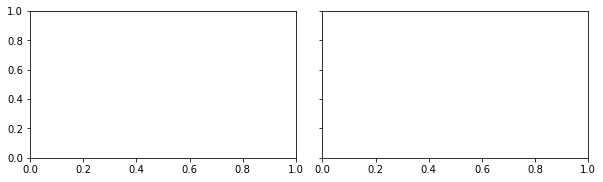

In [13]:
f, [ax1,ax2] = plt.subplots(figsize=[10,3],ncols=2,gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f.subplots_adjust(bottom=0.2)

handles= 'activated', 'inhibited'
        
tp.shadedError(ax1, lick_snips_a,linecolor='orange',errorcolor='yellow')
tp.shadedError(ax1, lick_snips_i,linecolor='darkgreen',errorcolor='green')

tp.shadedError(ax2, pump_snips_a,linecolor='orange',errorcolor='yellow')
tp.shadedError(ax2, pump_snips_i,linecolor='darkgreen',errorcolor='green') 


ax1.set_yticks([-0.5, 0,  0.5])
ax2.set_yticks([-0.5, 0,  0.5])
ax1.set_xticks([0,50,100,150])
ax2.set_xticks([0,50,100,150])
ax1.set_xticklabels([-5,0,5,10], fontsize=13)
ax2.set_xticklabels([-5,0,5,10], fontsize=13)
ax1.axvline(50, color='black', alpha=0.5, linewidth=1.2)
ax2.axvline(50, color='black', alpha=0.5, linewidth=1.2)

ax2.legend(handles, fontsize=13,frameon = False)

ax1.set_ylabel('Normalized Ca2+ activity',fontsize = 13)

ax1.set_xlabel('Time from lick (s)', fontsize = 13)
ax2.set_xlabel('Time from lick (s)', fontsize = 13)

ax1.set_title('PR',fontsize=15)
ax2.set_title('PRNR',fontsize=15)

# f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\signal_licks_118.png')

In [127]:
# f, [ax1,ax2] = plt.subplots(figsize=[10,3],ncols=2,gridspec_kw={'wspace':0.1,'width_ratios':[12,12]}, sharey=True)

# handles= 'Casein', 'Maltodextrin'
        
# # tp.shadedError(ax1, pump_snips_cas,linecolor='darkblue',errorcolor='blue') 
# tp.shadedError(ax1, pump_snips_malt,linecolor='darkred',errorcolor='red') 
# # tp.shadedError(ax2, pump_snips_cas2,linecolor='darkblue',errorcolor='blue') 
# # tp.shadedError(ax2, pump_snips_malt2,linecolor='darkred',errorcolor='red') 


# ax1.set_yticks([-0.5, 0,  0.5])

# ax1.set_xticks([0,50,100,150])
# ax2.set_xticks([0,50,100,150])
# ax1.set_xticklabels([-5,0,5,10], fontsize=13)
# ax2.set_xticklabels([-5,0,5,10], fontsize=13)
# ax1.axvline(50, color='black', alpha=0.5, linewidth=1.2)
# ax2.axvline(50, color='black', alpha=0.5, linewidth=1.2)

# ax2.legend(handles, fontsize=13,frameon = False)

# ax1.set_ylabel('Normalized Ca2+ activity',fontsize = 13)

# ax1.set_xlabel('Time from first lick (s)', fontsize = 13)
# ax2.set_xlabel('Time from first lick (s)', fontsize = 13)

# ax1.set_title('PR',fontsize=18)
# ax2.set_title('PRNR',fontsize=18)

# # f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\signal_pump_VGP310')

100 150


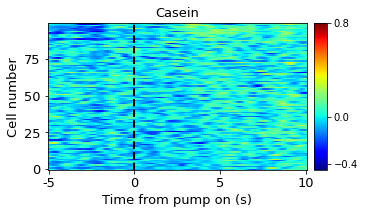

In [128]:
maxsignal=[np.max(signal[50:100]) for signal in snips_pump_cas]

f1, [ax1, ax2] = plt.subplots(figsize=[5,3],ncols=2, gridspec_kw={'wspace':0.05,'width_ratios':[10,0.5]})
f1.subplots_adjust(bottom=0.2)

ax1,mesh=make_heatmap(snips_pump_cas,events=maxsignal, ax=ax1)
cbar = f.colorbar(mesh, cax=ax2, ticks=[-0.4, 0, 0.8])
ax1.set_title('Casein', fontsize=13)


# maxsignal=[np.max(signal[50:100]) for signal in snips_lick_malt]

# f2,[ax1, ax2] = plt.subplots(figsize=[5,3],ncols=2, gridspec_kw={'wspace':0.05,'width_ratios':[10,0.5]})

# ax1,mesh=make_heatmap(snips_lick_malt,events=maxsignal, ax=ax1)
# cbar = f.colorbar(mesh, cax=ax2, ticks=[-0.4, 0, 0.8])
# ax1.set_title('Maltodextrin', fontsize=13)

# maxsignal=[np.max(signal[50:100]) for signal in snips_lick_cas2]

# f3,[ax1, ax2] = plt.subplots(figsize=[5,3],ncols=2, gridspec_kw={'wspace':0.05,'width_ratios':[10,0.5]})

# ax1,mesh=make_heatmap(snips_lick_cas2,events=maxsignal, ax=ax1)
# cbar = f.colorbar(mesh, cax=ax2, ticks=[-0.4, 0, 0.8])
# ax1.set_title('Casein PRNR', fontsize=13)


# maxsignal=[np.max(signal[50:100]) for signal in snips_lick_malt2]

# f4,[ax1, ax2] = plt.subplots(figsize=[5,3],ncols=2, gridspec_kw={'wspace':0.05,'width_ratios':[10,0.5]})

# ax1,mesh=make_heatmap(snips_lick_malt2,events=maxsignal, ax=ax1)
# cbar = f.colorbar(mesh, cax=ax2, ticks=[-0.4, 0, 0.8])
# ax1.set_title('Maltodextrin PRNR', fontsize=13)

f1.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\heat_cas_pump_VGP302.png')
# f2.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\heat_malt_VGP302.png')
# f3.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\heat_cas_PRNR_VGP203')
# f4.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\heat_malt_PRNR_VGP203')

## making functions for figures

In [129]:
def make_snipsplot(data1, data2, data3, data4): 
    
    f, ax = plt.subplots(figsize=[10,3],ncols=2,gridspec_kw={'wspace':0.1,'width_ratios':[12,12]}, sharey=True)

    handles= 'Casein', 'Maltodextrin'
        
    tp.shadedError(ax1, data1,linecolor='darkblue',errorcolor='blue') 
    tp.shadedError(ax1, data2,linecolor='darkred',errorcolor='red') 
    tp.shadedError(ax2, data3,linecolor='darkblue',errorcolor='blue') 
    tp.shadedError(ax2, data4,linecolor='darkred',errorcolor='red') 


    ax1.set_yticks([-0.5, 0,  0.5])
    ax2.set_yticks([-0.5, 0,  0.5])
    ax1.set_xticks([0,50,100,150])
    ax2.set_xticks([0,50,100,150])
    ax1.set_xticklabels([-5,0,5,10], fontsize=13)
    ax2.set_xticklabels([-5,0,5,10], fontsize=13)
    ax1.axvline(50, color='black', alpha=0.5, linewidth=1.2)
    ax2.axvline(50, color='black', alpha=0.5, linewidth=1.2)

    ax2.legend(handles, fontsize=13,frameon = False)

    ax1.set_ylabel('Normalized Ca2+ activity',fontsize = 13)

    ax1.set_xlabel('Time from first lick (s)', fontsize = 13)
    ax2.set_xlabel('Time from first lick (s)', fontsize = 13)

    ax1.set_title('PR',fontsize=18)
    ax2.set_title('PRNR',fontsize=18)
    
    return f




In [ ]:
f = make_snipsplot(lick_snips_cas,lick_snips_malt,lick_snips_cas2,lick_snips_malt2)